# NLP Tutorial

-- Sridhar D Kamoji

### Note: this tutorial is run on a high end laptop with GPU

This NLP tutorial covers the applied part of nlp concepts starting from basics to advanced. <br>
This tutorial includes:<br>
<ol>
    A. <b> Text Preprocessing </b> <br>
    <br>
    B.1 <b> Text featurization </b>
    <ol>
        1. Bag-of-Words <br>
        2. TF-IDF (Term Frequency - Inverse Document Frequency)<br>
        3. Word2Vec, FastText<br>
        4. BERT
    </ol>
    B.2 <b> Text Vizualization using PCA and t-SNE </b> <br>
         <ol>
             Converting High Dimensional data into low dimension to visualize
         </ol>    
    <br>
    C.  <b> Machine Learning Modelling </b>
    <ol>
        1. Logistic Regression <br>
        2. SVM <br>
    </ol>
    <br>
    D. <b> Deep Learning Modelling - This would be run on GPU </b>
    <ol>
        1. ANN (Artificial Neural Network) <br>
        2. CNN (Convolution Neural Network) <br>
        3. LSTM (Long Short Term Memory) Networks <br>
        4. RESNET <br>
    </ol>
</ol>


In [1]:
from urllib.request import urlopen 
from urllib.parse import urlparse
import numpy as np
from urllib.error import HTTPError
from urllib.error import URLError

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import itertools
import spacy
import random
import datetime
import ssl

from sklearn.metrics.pairwise import cosine_similarity
from spellchecker import SpellChecker
import itertools

import spacy
import pandas as pd 
import gensim
import ast
from sklearn.metrics.pairwise import cosine_similarity

import os
import wordcloud
from collections import Counter
from nltk.util import ngrams 
from bs4 import BeautifulSoup , NavigableString
import re 
import datetime 
import random
import pickle
import string
import urllib.request
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import string
import pickle
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
tf.test.is_built_with_gpu_support()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

True

True

In [3]:
conn = sqlite3.connect('./database.sqlite')
data = pd.read_sql_query('select * from reviews', conn)

In [4]:
data.shape
data.head()

(568454, 10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Target Variable exploration

1. We will try to predict the score based on the customers' review. <br>
2. we will treat score 4 and 5 to be positive, <br> 
    1 and 2 to be negative and <br>
    3 to be neutral. <br>
3. Once we convert the score into 3 classes, it is better to get an understanding of the distribution. Whether the data is balanced or imbalanced

In [5]:
# {'Postive':1, 'Negative':0, 'Neutral':2}
def convert_to_numeric_score(row):
    if row['Score'] == 4 or row['Score'] == 5:
        return 1 # Positive
    elif row['Score'] == 1 or row['Score'] == 2:
        return 0 # Negative
    else:
        return 2 # Neutral
    
    
data['numeric_score'] = data.apply(convert_to_numeric_score,1)

In [6]:
(data.numeric_score.value_counts() / data.shape[0]) * 100
data.numeric_score.value_counts()

1    78.067355
0    14.431599
2     7.501047
Name: numeric_score, dtype: float64

1    443777
0     82037
2     42640
Name: numeric_score, dtype: int64

<BarContainer object of 3 artists>

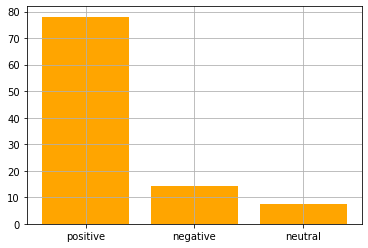

In [7]:
plt.bar(x = ['positive', 'negative', 'neutral'], height=(data.numeric_score.value_counts() / data.shape[0]) * 100 , color = 'orange')
plt.grid()
plt.show()

The graph above shows that we are dealing with class imbalance problem with majority being positive

#### Removing rows that have HelpfulnessDenominator < HelpfulnessNumerator

In [8]:
#Common sense indicates that helpfulness denominator should not be less than numerator
data[data.HelpfulnessDenominator < data.HelpfulnessNumerator].shape
data[data.HelpfulnessDenominator < data.HelpfulnessNumerator]

(2, 11)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,numeric_score
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,1
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,1


In [9]:
ind_to_drop = data[data.HelpfulnessDenominator < data.HelpfulnessNumerator].index
data.drop(index= ind_to_drop, inplace=True)
data.reset_index(drop=True, inplace= True)

#### Removing Duplicates on 'ProductId', 'UserId', 'ProfileName', 'Time', 'Text' columns

In [10]:
data.shape
data.drop_duplicates(subset=['ProductId', 'UserId', 'ProfileName', 'Time', 'Text'], inplace=True)
data.shape

(568452, 11)

(567247, 11)

1205 duplicate records are removed

#### Sort the data by 'Time' column

In [11]:
data.sort_values(by = 'Time', inplace=True)
data.reset_index(drop=True, inplace=True)

### Text Preprocessing code

Text Preprocessing involes the following<br>
<ol>
    1. Removal of special characteristics, digits, HTML tags, urls in the text <br>
    2. Lower case conversion <br>
    3. Stop words removal - Stop words are those words that even after removal the meaning of the text remains same.<br>
    4. Spell correction<br>
    5. Root word conversion - also known as stemming or lemmatization (both are different)<br>


In [3]:
class extract_stopwords():
    ''' this class is used to extract a list of long stop words list from 
        https://www.ranks.nl/stopwords 
        Thanks to these ppl for providing this list'''
    def __init__(self):
        pass
    
    def extract_stopwords(self):
        # Extracting long stop words
        user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36'
        
        headers={'User-Agent':user_agent} 
        cont = ssl._create_unverified_context()

        url = r'https://www.ranks.nl/stopwords'
        request=urllib.request.Request(url, None, headers)
        response = urllib.request.urlopen(request, context=cont)

        data = response.read()
        sw_soup = BeautifulSoup(data)
        tbls = sw_soup.find_all('table')
        req_tbl = tbls[3]

        for i, item in enumerate(req_tbl.findAll('tr')):
            stp_wd = [item.findAll('td')[i].findAll(text=True) for i in range(len(item.findAll('td')))]

        stop_words = list(itertools.chain.from_iterable(stp_wd))
        stop_words = [x.lower() for x in stop_words]
        return stop_words
    
    
class Preprocess_text():
    '''Used to preprocess text.
       Just pass True/False as the parameter to the operation you want to perform on the text and 
       call the preprocess_text() function by passing the text as argument. 
    '''
    def __init__(self, special_char_rem= True, rem_urls = True, rem_digits = True, spell_correction = False,
                 l_case = False, stop_words_rem = True, stemming=False, lemmatization_ = False, 
                 remove_nasdaq_comp_ticker = True, rem_html_tags = True):
        
        self.special_char_rem = special_char_rem
        self.rem_digits = rem_digits
        self.l_case = l_case
        self.stop_words_rem = stop_words_rem
        self.stemming = stemming
        self.lemmatization_ = lemmatization_
        self.spell_correction = spell_correction
        self.rem_urls = rem_urls
        self.remove_nasdaq_comp_ticker = remove_nasdaq_comp_ticker
        self.rem_html_tags = rem_html_tags
        
        if (self.lemmatization_ and self.stemming):
            # priority given to lemmatization
            self.stemming = False
        
        if self.lemmatization_:
            self.stemming = False
            
        elif self.stemming:
            self.lemmatization_ = False
        
            
        if self.lemmatization_:
            self.nlp = spacy.load("en_core_web_sm")
        
        if self.stemming:
            self.ps = nltk.porter.PorterStemmer()
        
        if self.stop_words_rem:
            try:
                self.stop_words = pickle.load(open('./long_stop_words_list.pkl', 'rb'))
            except:
                try:
                    self.stop_words = extract_stopwords().extract_stopwords()
                    pickle.dump(self.stop_words, open('./long_stop_words_list.pkl', 'wb'))
                except:
                    self.stop_words = stopwords('english')

            

    
    def remove_urls(self, text):
        soup = BeautifulSoup(text, "html.parser")
        [s.extract() for s in soup(['iframe', 'script'])]
        stripped_text = soup.get_text()
        stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
        return stripped_text
    
    def remove_html_tags(self, text):
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text
    
    def remove_nasdaq_str(self, text):
        pattern = r'nasdaq [a-z0-9]{2,5}'
        text = re.sub(pattern, ' ', text.lower())
        text = re.sub('\s+', ' ', text)
        return text
    
    def simple_stemming(self, text):
        stemmer=self.ps
        text = ' '.join([stemmer.stem(word) for word in text.split()])
        return text
    
    def simple_lemma(self, text, pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
        doc = self.nlp(text)
        lemm_txt = [token.lemma_ for token in doc if token.pos_ in pos_tags]
        lemm_txt = ' '.join(lemm_txt)
        return lemm_txt
    

    def lower_case(self, text):
        text = ' '.join([token.lower() for token in text.split()])
        return text

    def remove_special_characters(self, text, remove_digits= True):
        pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
        text = re.sub(pattern, ' ', text)
        text = re.sub('\s+', ' ', text)
        return text
    
    def spell_corrector(self, text):
        spell = SpellChecker()
        tokens = text.split()
        tokens = [token.strip() for token in tokens]
        corrected_tokens = [spell.correction(token) for token in tokens]
        text = ' '.join(corrected_tokens)
        return text

    def remove_stopwords(self, text, is_lower_case=False):
        stopwords = self.stop_words
        tokens = text.split()
    #     tokens = nltk.word_tokenize(text)

        tokens = [token.strip() for token in tokens]

        if is_lower_case:
            filtered_tokens = [token for token in tokens if token not in stopwords]
        else:
            filtered_tokens = [token for token in tokens if token.lower() not in stopwords]

        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    
    def preprocess_text(self, text):  
        
        if self.rem_urls:
            text = self.remove_urls(text)

        if self.rem_html_tags:
            text = self.remove_html_tags(text)
            
        if self.special_char_rem:
            text = self.remove_special_characters(text, remove_digits=self.rem_digits)
            
        if self.remove_nasdaq_comp_ticker:
            text = self.remove_nasdaq_str(text)
            
        if self.spell_correction:
            text = self.spell_corrector(text)

        if self.l_case:
            text = self.lower_case(text)

        if self.stop_words_rem:
            text = self.remove_stopwords(text)

        if self.stemming:
            text = self.simple_stemming(text)
            
        if self.lemmatization_:
            text = self.simple_lemma(text)
            
        self.text = text

        return self.text

### Preprocessing the Text

In [ ]:
pp_text = Preprocess_text(special_char_rem=True, 
                          rem_digits=True, 
                          rem_urls=True, 
                          stop_words_rem=True, 
                          lemmatization_=True, 
                          stemming=False, 
                          remove_nasdaq_comp_ticker=False, 
                          rem_html_tags=True, 
                          spell_correction=False, 
                          l_case=True,)

# this cleaned_text will be used for BOW and TFIDF vectorization techniques
data['cleaned_text'] = [pp_text.preprocess_text(text) for text in data['Text']]

#######################################################################################################################

pp_text_wv = Preprocess_text(special_char_rem=True, 
                          rem_digits=True, 
                          rem_urls=True, 
                          stop_words_rem=False, 
                          lemmatization_=False, 
                          stemming=False, 
                          remove_nasdaq_comp_ticker=False, 
                          rem_html_tags=True, 
                          spell_correction=False, 
                          l_case=True)

# this cleaned_text_wv will be used for word vector and FastText vectorization techniques
data['cleaned_text_wv'] = [pp_text_wv.preprocess_text(text) for text in data['Text']]

# we will do some EDA on the num of words to decide the number of words we need to take DL algo
data['len_text_wv'] = [len(txt.split()) for txt in data.cleaned_text_wv]

In [15]:
# Save the data instead of running from begginning
# pickle.dump(data, open('./amzn_food_reviews_preprocessed.pkl', 'wb'))

In [4]:
data = pickle.load(open('./amzn_food_reviews_preprocessed.pkl', 'rb'))

In [5]:
print("Sample Raw Text:")
data['Text'].values[30]

print("Cleaned Text:")
data['cleaned_text'].values[30]

print("Cleaned Text for WV:")
data['cleaned_text_wv'].values[30]

Sample Raw Text:


"Beetlejuice is an awe-inspiring wonderfully amusing comedic romp that explores the incredible possibilities of the after-life and the boundaries of the absurd. Telling the tale of a recently dead married couple that suddenly gets led into the chaotic world of the supernatural. Adam and Barbara Maitland (Alec Baldwin and Geena Davis) discover many of the conflicting rather human imperfections that haunt the lives of the living also plague the afterlife as well.<p>Unlike some film projects that seemed to be blindly assigned to dispassionate filmmakers for commercial reasons, Beetlejuice's plot and bizarre subject matter remarkably complemented Burton's unusually macabre artistic sensibilities extraordinarily well. Created by the unbelievably brilliant guidance of imaginative film director, Tim Burton (Pee Wee's Big Adventure, Batman, Ed Wood, Sleepy Hollow). The film's uniquely creative landscape was a culmination of essentially all of the abundant irony and outlandish yet human behavio

Cleaned Text:


'awe inspire wonderfully amusing comedic romp explore incredible possibility life boundary absurd tell tale dead married couple suddenly lead chaotic supernatural adam barbara maitland alec baldwin geena davi discover conflict human imperfection haunt life live plague afterlife well film project blindly assign dispassionate filmmaker commercial reason plot bizarre subject matter remarkably complement burton unusually macabre artistic sensibility extraordinarily well create unbelievably brilliant guidance imaginative film director tim burton pee wee big adventure batman wood sleepy hollow film uniquely creative landscape culmination essentially abundant irony outlandish human behavior grace body burton work augment deviously energetic performance glenn shadix jeffrey jone winona ryder catherine hara geena davi alec baldwin film bustle uninhibite brilliant hilarity persistently push film level affable euphoria pair ingenious screenplay tour force performance michael beetlejuice film tran

Cleaned Text for WV:


'beetlejuice is an awe inspiring wonderfully amusing comedic romp that explores the incredible possibilities of the after life and the boundaries of the absurd telling the tale of a recently dead married couple that suddenly gets led into the chaotic world of the supernatural adam and barbara maitland alec baldwin and geena davis discover many of the conflicting rather human imperfections that haunt the lives of the living also plague the afterlife as well unlike some film projects that seemed to be blindly assigned to dispassionate filmmakers for commercial reasons beetlejuice s plot and bizarre subject matter remarkably complemented burton s unusually macabre artistic sensibilities extraordinarily well created by the unbelievably brilliant guidance of imaginative film director tim burton pee wee s big adventure batman ed wood sleepy hollow the film s uniquely creative landscape was a culmination of essentially all of the abundant irony and outlandish yet human behaviors that have gra

### Train Test Split

Split the data into train and test. <br>
we will use train data to vectorize and build the model and use the parameters learnt from the train data to transform the test data and test the model performance.

In [6]:
train_data = data.loc[0:int(0.7*data.shape[0])]
test_data = data.loc[int(0.7*data.shape[0]):]

train_data.shape
test_data.shape

(397073, 14)

(170175, 14)

### Text Data Exploration

Lets explore the length of the reviews which will help us to limit out vector length for deep learning models when we try to stack the word vectors horizontally

<Figure size 1440x432 with 0 Axes>

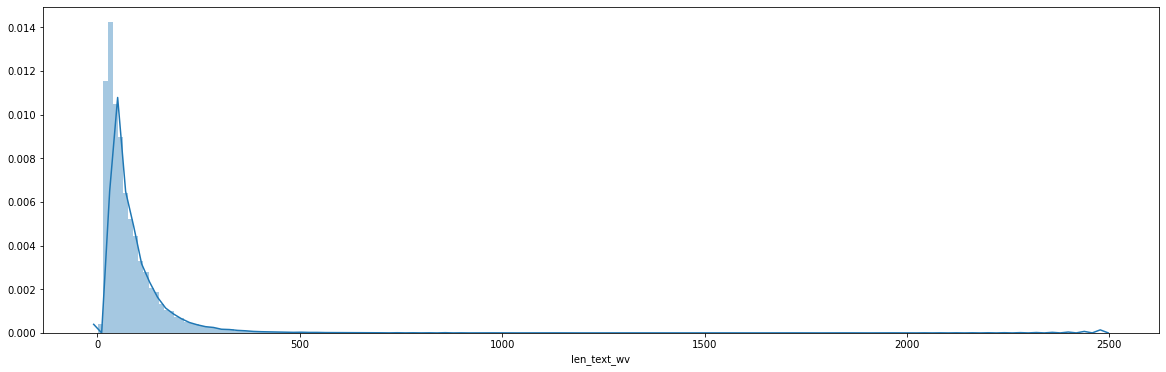

<Figure size 1440x432 with 0 Axes>

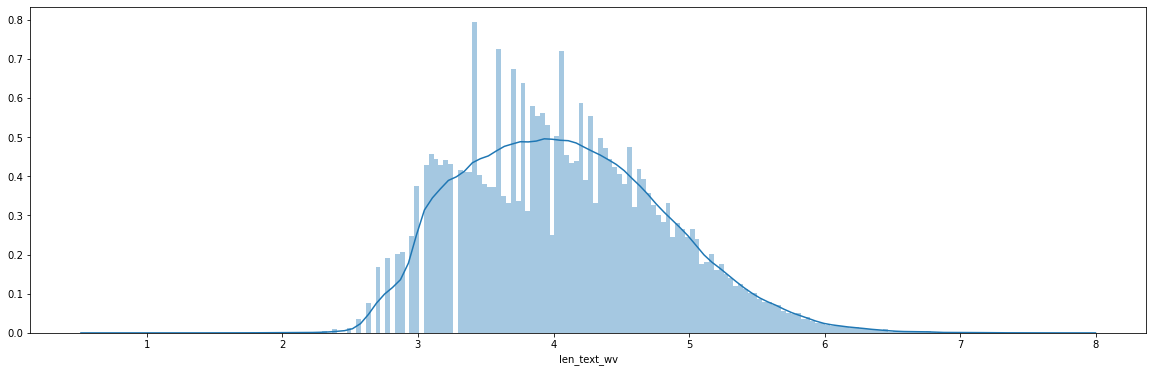

In [8]:
plt.figure(figsize= (20,6))
sns.distplot(train_data.len_text_wv, bins = 200)
plt.show()

plt.figure(figsize= (20,6))
sns.distplot(np.log(train_data.len_text_wv), bins = 200)
plt.show()

In [20]:
for i in range(0,100,10):
    x = train_data.len_text_wv.values.copy()
    x = np.sort(x)
    print('{} percentile: {}'.format(i, x[int(len(x)*float(i)/100)]))


for i in range(91, 100, 1):
    x = train_data.len_text_wv.values.copy()
    x = np.sort(x)
    print('{} percentile: {}'.format(i, x[int(len(x)*float(i)/100)]))
print('100 percentile: {}'.format(x[-1]))

0 percentile: 2
10 percentile: 23
20 percentile: 30
30 percentile: 37
40 percentile: 46
50 percentile: 56
60 percentile: 69
70 percentile: 86
80 percentile: 111
90 percentile: 158
91 percentile: 166
92 percentile: 176
93 percentile: 186
94 percentile: 198
95 percentile: 213
96 percentile: 232
97 percentile: 259
98 percentile: 298
99 percentile: 371
100 percentile: 2486


 <b> We can see that 95th percentile has 213 as len of the text. <br>
Let's use 200 as the length max vector size for DL model

Lets try to explore the reviews data by looking at the top phrases that appear in each class

In [21]:
# {'Postive':1, 'Negative':0, 'Neutral':2}
pos_data = train_data[train_data.numeric_score == 1]['cleaned_text'].copy()
neg_data = train_data[train_data.numeric_score == 0]['cleaned_text'].copy()
neu_data = train_data[train_data.numeric_score == 2]['cleaned_text'].copy()

pos_vec = TfidfVectorizer(ngram_range=(3,3), min_df=5, max_features=100).fit(pos_data)
neg_vec = TfidfVectorizer(ngram_range=(3,3), min_df=5, max_features=100).fit(neg_data)
neu_vec = TfidfVectorizer(ngram_range=(3,3), min_df=5, max_features=100).fit(neu_data)

pos_tokens = [re.sub(' ', '_', token) for token in pos_vec.get_feature_names()]
neg_tokens = [re.sub(' ', '_', token) for token in neg_vec.get_feature_names()]
neu_tokens = [re.sub(' ', '_', token) for token in neu_vec.get_feature_names()]

## Vizualization

### Phrase Cloud

#### Positive Class

(-0.5, 699.5, 399.5, -0.5)

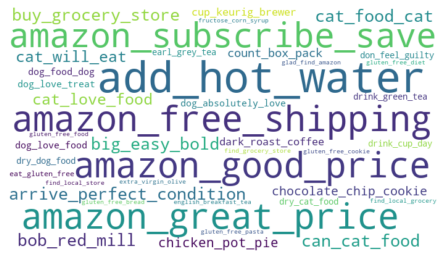

In [22]:
wdcld = wordcloud.WordCloud(prefer_horizontal=2, width=700,height=400, 
                            min_font_size=10, background_color="white",mode='RGBA').generate(' '.join(pos_tokens))
plt.imshow(wdcld, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### Negative Class

(-0.5, 699.5, 399.5, -0.5)

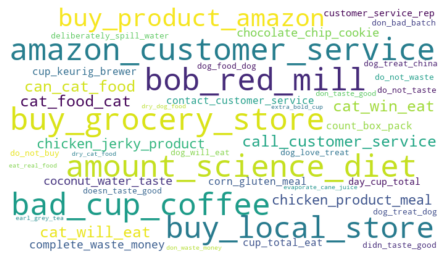

In [23]:
wdcld = wordcloud.WordCloud(prefer_horizontal=2, width=700,height=400, min_font_size=10, 
                            background_color="white",mode='RGBA').generate(' '.join(neg_tokens))
plt.imshow(wdcld, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### Neutral Class

(-0.5, 699.5, 399.5, -0.5)

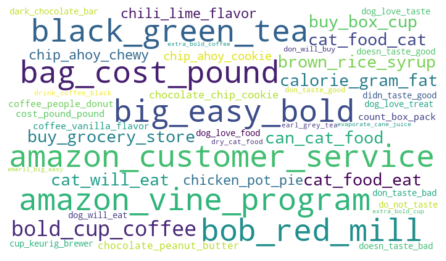

In [24]:
wdcld = wordcloud.WordCloud(prefer_horizontal=2, width=700,height=400, min_font_size=10, 
                            background_color="white",mode='RGBA').generate(' '.join(neu_tokens))
plt.imshow(wdcld, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Vectorizing the Text

We will try out different techniques for vectorizing the text data. <br>
<ol>
    Frequency Based Vectorization <br>
    <ol>
        1. BOW - Bag of Words <br>
        2. TFIDF - Term Frequency Inverse Document Frequency <br>
    </ol>
    Semantic based Vectorization <br>
    <ol>
        1. Word Vector / FastText (FastText is advancement of Google's Word2Vec developed by Facebook) <br>
        2. BERT - We will use pretrained model - distilbert (transformers package from huggingface) <br>

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Initializing the vectorizers, fit them on the preprocessed text. <br>
NOTE: During the fit method, the model learns the vocabulary, hence it is recommended to fit on train dataset and use the learned vocabulary to transform on the test dataset 

In [ ]:
# bow_vec = CountVectorizer(ngram_range=(1,3), min_df=5, max_features=50000).fit(train_data.cleaned_text)
# tfidf_vec = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_features=50000).fit(train_data.cleaned_text)
# ft_model = gensim.models.FastText(train_data.cleaned_text_wv,size = 300, window=5, min_count=5, seed=1)


#### Saving the vectorizers in order to avoid to fit them always

# pickle.dump(bow_vec, open('./BOW_vectorizer.pkl', 'wb'))
# pickle.dump(tfidf_vec, open('./TFIDF_vectorizer.pkl', 'wb'))
# pickle.dump(ft_model, open('./FastText_model.pkl', 'wb'))

------------------------------------------------------------------------------------------------------------------------

## BERT

In [7]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig

In [9]:
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig.from_pretrained(distil_bert, output_hidden_states = True)
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert)
model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

### Sample Tutorial for Bert

In [11]:
sample_text = 'I have two cats which are extremely naughty!'
enc = tokenizer.encode(sample_text) # tokenize in such way that the bert model expects
dec = tokenizer.decode(enc)

[(enc_, dec_) for (enc_,dec_) in zip(enc,dec.split())]

[(101, '[CLS]'),
 (1045, 'i'),
 (2031, 'have'),
 (2048, 'two'),
 (8870, 'cats'),
 (2029, 'which'),
 (2024, 'are'),
 (5186, 'extremely'),
 (20355, 'naughty!'),
 (999, '[SEP]')]

In [12]:
inp = tf.constant(enc) # input needs to be of tensorflow tensor with [batch_size, inp_shape] as the shape. 
inp = tf.reshape(inp, [1,inp.shape[0]])
vec = model(inp)

In [13]:
print(inp)
# tf.Tensor([[  101  1045  2031  2048  8870  2029  2024  5186 20355   999   102]], shape=(1, 11), dtype=int32)

print(type(inp))
# <class 'tensorflow.python.framework.ops.EagerTensor'>

print(inp.shape)
# (1, 11)

type(vec)
# tuple

len(vec[1])
# 7 because we are getting outputs of all the layers in the distilbert 
# that is initialized on the config which says output_hidden_states = True

vec
# the output is a tuple with 2 elements
# vec[0] --> the output of last layer of the bert model with shape [batch_size, #tokens in the document after tokenizing, vec_size]
# vec[1] --> the output of all the hidden layers starting from the 1st layer to last layer
# vec[1][0] --> the output of 1st hidden layer in the transformer model

tf.Tensor([[  101  1045  2031  2048  8870  2029  2024  5186 20355   999   102]], shape=(1, 11), dtype=int32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 11)


tuple

7

(<tf.Tensor: shape=(1, 11, 768), dtype=float32, numpy=
 array([[[ 0.02047714,  0.05357037,  0.06774443, ..., -0.08473192,
           0.4152077 ,  0.39752215],
         [ 0.63638616,  0.00156502, -0.0199237 , ..., -0.06730115,
           0.636697  ,  0.4045915 ],
         [ 0.40268645,  0.45753267,  0.20124474, ..., -0.67726743,
           0.3876128 ,  0.17941162],
         ...,
         [ 0.24747136, -0.08266954,  0.23705946, ..., -0.26043615,
           0.17975837, -0.548524  ],
         [ 0.24229333,  0.20419756,  0.07773688, ...,  0.19162394,
           0.49024963, -0.17992961],
         [ 0.89985484,  0.48636305, -0.25632623, ...,  0.11732695,
          -0.10952236, -0.31411558]]], dtype=float32)>,
 (<tf.Tensor: shape=(1, 11, 768), dtype=float32, numpy=
  array([[[ 0.34693524, -0.16263762, -0.23334563, ...,  0.14869013,
            0.08653457,  0.14215374],
          [ 0.2053848 ,  0.5164093 , -0.5313251 , ...,  0.66770977,
            1.0128667 ,  0.45773804],
          [-0.288400

In [11]:
sum([(vec[1][layer][0][0]) for layer in range(7)])
# we will take sum of all vectors corresponding to [cls] token of the hidden layers to represent the document vector

<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([ 8.47010672e-01, -1.74986887e+00, -1.56749845e-01, -7.16703892e-01,
       -5.93804717e-01, -1.64998698e+00, -1.06644273e+00,  6.05072618e-01,
       -2.24318218e+00, -1.47302485e+00,  4.16505456e-01,  1.49591279e+00,
       -1.34093451e+00,  2.88791060e-02, -1.35780901e-01,  1.16675508e+00,
       -2.48283461e-01,  2.21795392e+00,  7.37052798e-01, -9.61056828e-01,
       -3.31797314e+00,  2.82308042e-01, -1.00706661e+00, -1.01244259e+00,
        1.20930851e+00, -2.98735499e-01, -1.10103130e+00,  8.66854072e-01,
        5.14524162e-01,  5.35669982e-01, -8.54442716e-01, -1.29090321e+00,
       -3.48740667e-01,  9.39394653e-01, -1.72415304e+00,  4.05190885e-02,
       -1.53755680e-01,  1.08050907e+00, -1.69705474e+00,  4.71711814e-01,
        2.98115849e-01, -9.48759556e-01,  5.19085586e-01, -1.41683650e+00,
       -7.12287664e-01, -3.56444716e-01, -2.25480785e+01,  1.23637676e+00,
        2.29497838e+00, -1.57824183e+00,  5.15050268

In [71]:
# we need to concat vectors of at least last 3-4 the layers to get better results from the model (ref BERT paper) 
l = [
    [[1,2],
     [3,4],
     [4,5]],
    [[6,7], 
     [8,9],
     [10,22]
    ]
]
tf.concat(l,1)

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  6,  7],
       [ 3,  4,  8,  9],
       [ 4,  5, 10, 22]])>

In [75]:
tf.concat([vec[1][l][0] for l in range(3,7)], 1)[0]

<tf.Tensor: shape=(3072,), dtype=float32, numpy=
array([ 0.21103397, -0.34622476, -0.02139368, ..., -0.08473192,
        0.4152077 ,  0.39752215], dtype=float32)>

In [87]:
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig.from_pretrained(distil_bert, output_hidden_states = True)
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert)
model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

def get_vec_concat_from_bert(texts, bert_tokenizer, bert_model, hidden_layers_to_consider, maxlen = 512, batch_size = 1024):
    '''
    Function to represent text to vector using BERT models.
    texts: lists of text
    hidden_layers_to_consider: the number of last hidden layers to consider if the config of bert model outputs hidden states.
    hidden_layers_to_consider = 4 then the last 4 output layers of bert model is used to get the concatenated vector
    '''
    hidden_states = bert_model.config.output_hidden_states        
        
    n_layers = bert_model.config.n_layers + 1
    
    if hidden_layers_to_consider > n_layers:
        hidden_layers_to_consider = n_layers
    
    if maxlen > 512:
        maxlen = 512
    
    enc_texts = [tokenizer.encode(txt, truncation = True, max_length = maxlen) for txt in texts]
    inp_tokens = [tf.constant(enc_txt)[None, :] for enc_txt in enc_texts]    
    
    no_batches = len(texts) // batch_size
    print('#batches for batch_size {0}: {1}'.format(batch_size, no_batches))
    
    vectors = []
    for batch in range(no_batches + 1):
        
        if batch % 5 == 0:
            print('processing batch: {0} of {1}'.format(batch, no_batches))
        
        inputs = inp_tokens[batch * batch_size : (batch+1) * batch_size]
        batch_vectors = [model(inp) for inp in inputs]
        
        if hidden_states:
            #tf.concat([vec[1][l][0] for l in range(3,7)], 1)
            batch_vectors = [tf.concat([(vec[1][n_layers - (layer + 1)][0])
                                       for layer in range(hidden_layers_to_consider)], 1)[0]
                             for vec in batch_vectors]
        else:
            batch_vectors = [vec[0][0][0] for vec in batch_vectors]

        batch_vectors = [vec.numpy() for vec in batch_vectors]
        vectors.append(batch_vectors)
        
    vectors = np.concatenate(vectors)
    
    return vectors

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [95]:
sample_text_list = ['I have two cats which are extremely naughty!', 
                    'one of my cat ate my homework']
vectors = get_vec_concat_from_bert(sample_text_list, tokenizer, model, hidden_layers_to_consider=3)

#batches for batch_size 1024: 0
processing batch: 0 of 0


In [97]:
vectors.shape
# since we are concatenating the vectors, the dimension is no_layers * output dimn of that of the bert model.

(2, 2304)

In [91]:
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig.from_pretrained(distil_bert, output_hidden_states = True)
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert)
model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

def get_vec_from_bert(texts, bert_tokenizer, bert_model, hidden_layers_to_consider, maxlen = 512, batch_size = 1024):
    '''
    Function to represent text to vector using BERT models.
    texts: lists of text
    hidden_layers_to_consider: the number of last hidden layers to consider if the config of bert model outputs hidden states.
    hidden_layers_to_consider = 4 then the last 4 output layers of bert model is used to calculate the sum of vector.
    '''
    hidden_states = bert_model.config.output_hidden_states        
        
    n_layers = bert_model.config.n_layers + 1
    
    if hidden_layers_to_consider > n_layers:
        hidden_layers_to_consider = n_layers
    
    if maxlen > 512:
        maxlen = 512
    
    enc_texts = [tokenizer.encode(txt, truncation = True, max_length = maxlen) for txt in texts]
    inp_tokens = [tf.constant(enc_txt)[None, :] for enc_txt in enc_texts]    
    
    no_batches = len(texts) // batch_size
    print('#batches for batch_size {0}: {1}'.format(batch_size, no_batches))
    
    vectors = []
    for batch in range(no_batches + 1):
        
        if batch % 5 == 0:
            print('processing batch: {0} of {1}'.format(batch, no_batches))
        
        inputs = inp_tokens[batch * batch_size : (batch+1) * batch_size]
        batch_vectors = [model(inp) for inp in inputs]
        
        if hidden_states:
            batch_vectors = [sum((vec[1][n_layers - (layer + 1)][0][0]) 
                                 for layer in range(hidden_layers_to_consider)) 
                             for vec in batch_vectors]
        else:
            batch_vectors = [vec[0][0][0] for vec in batch_vectors]

        batch_vectors = [vec.numpy() for vec in batch_vectors]
        vectors.append(batch_vectors)
        
    vectors = np.concatenate(vectors)
    
    return vectors

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [106]:
sample_text_list = ['I have two cats which are extremely naughty!', 
                    'one of my cat ate my homework']
vectors = get_vec_from_bert(sample_text_list, tokenizer, model, hidden_layers_to_consider=7)

#batches for batch_size 1024: 0
processing batch: 0 of 0


In [107]:
vectors.shape
# the sum produces the same dimension as that of the output of the bert model

(2, 768)

In [24]:
train_bert_vectors = get_vec_from_bert(list(train_data.Text), tokenizer, model, 
                                       hidden_layers_to_consider=7, maxlen=200, batch_size=1024)

#batches for batch_size 1024: 387
processing batch: 0 of 387
processing batch: 5 of 387
processing batch: 10 of 387
processing batch: 15 of 387
processing batch: 20 of 387
processing batch: 25 of 387
processing batch: 30 of 387
processing batch: 35 of 387
processing batch: 40 of 387
processing batch: 45 of 387
processing batch: 50 of 387
processing batch: 55 of 387
processing batch: 60 of 387
processing batch: 65 of 387
processing batch: 70 of 387
processing batch: 75 of 387
processing batch: 80 of 387
processing batch: 85 of 387
processing batch: 90 of 387
processing batch: 95 of 387
processing batch: 100 of 387
processing batch: 105 of 387
processing batch: 110 of 387
processing batch: 115 of 387
processing batch: 120 of 387
processing batch: 125 of 387
processing batch: 130 of 387
processing batch: 135 of 387
processing batch: 140 of 387
processing batch: 145 of 387
processing batch: 150 of 387
processing batch: 155 of 387
processing batch: 160 of 387
processing batch: 165 of 387
pr

In [28]:
test_bert_vectors = get_vec_from_bert(list(test_data.Text), tokenizer, model, 
                                      hidden_layers_to_consider=7, maxlen=200, batch_size=1024)

#batches for batch_size 1024: 166
processing batch: 0 of 166
processing batch: 5 of 166
processing batch: 10 of 166
processing batch: 15 of 166
processing batch: 20 of 166
processing batch: 25 of 166
processing batch: 30 of 166
processing batch: 35 of 166
processing batch: 40 of 166
processing batch: 45 of 166
processing batch: 50 of 166
processing batch: 55 of 166
processing batch: 60 of 166
processing batch: 65 of 166
processing batch: 70 of 166
processing batch: 75 of 166
processing batch: 80 of 166
processing batch: 85 of 166
processing batch: 90 of 166
processing batch: 95 of 166
processing batch: 100 of 166
processing batch: 105 of 166
processing batch: 110 of 166
processing batch: 115 of 166
processing batch: 120 of 166
processing batch: 125 of 166
processing batch: 130 of 166
processing batch: 135 of 166
processing batch: 140 of 166
processing batch: 145 of 166
processing batch: 150 of 166
processing batch: 155 of 166
processing batch: 160 of 166
processing batch: 165 of 166


In [ ]:
train_bert_vectors_con = get_vec_concat_from_bert(list(train_data.Text), tokenizer, model, 
                                       hidden_layers_to_consider=3, maxlen=200, batch_size=1024)

In [ ]:
test_bert_vectors_con = get_vec_concat_from_bert(list(test_data.Text), tokenizer, model, 
                                      hidden_layers_to_consider=3, maxlen=200, batch_size=1024)

In [27]:
# pickle.dump(train_bert_vectors, open('./bert_train_vectors.pkl', 'wb'))
# pickle.dump(test_bert_vectors, open('./bert_test_vectors.pkl', 'wb'))

In [11]:
bow_vec = pickle.load(open('./BOW_vectorizer.pkl', 'rb'))
tfidf_vec = pickle.load(open('./TFIDF_vectorizer.pkl', 'rb'))
ft_model = pickle.load(open('./FastText_model.pkl', 'rb'))

In [12]:
class avg_wv():
    '''
    AVG Word Vector
    Document to vector conversion --> we will add all the word vectors that appear in the document 
    and divide the vector by the number of words that appear in the document
    '''
    def __init__(self, model, texts, wv_size = 300):
        self.model = model
        self.texts_dict = dict(pd.Series(texts))
        self.vec_size = wv_size
        
    def avg_wv_generation(self):
        self.avg_wv_list = []
        for key, item in self.texts_dict.items():
            avg_sentvec = np.zeros(self.vec_size)
            
            words = item.split()
            cnt_wrds = 0
            for word in words:
                try:
                    vec = self.model.wv[word]
                    avg_sentvec += vec
                    cnt_wrds += 1
                except KeyError:
                    pass
            
            if cnt_wrds != 0:
                avg_sentvec = avg_sentvec/cnt_wrds

            self.avg_wv_list.append(avg_sentvec)
            
        return self.avg_wv_list

## Run the Below Cell once and Comment the entire Cell

In [ ]:
# x_train_bow = bow_vec.transform(train_data.cleaned_text)
# x_test_bow = bow_vec.transform(test_data.cleaned_text)

# x_train_tfidf = tfidf_vec.transform(train_data.cleaned_text)
# x_test_tfidf = tfidf_vec.transform(test_data.cleaned_text)

# x_train_avg_wv = avg_wv(model=ft_model, texts=train_data.cleaned_text_wv, wv_size=300).avg_wv_generation()
# x_test_avg_wv = avg_wv(model=ft_model, texts=test_data.cleaned_text_wv, wv_size=300).avg_wv_generation()

# x_train_avg_wv = np.array(x_train_avg_wv)
# x_test_avg_wv = np.array(x_test_avg_wv)

# pickle.dump(x_train_bow, open('./x_train_bow', 'wb'))
# pickle.dump(x_test_bow, open('./x_test_bow', 'wb'))

# pickle.dump(x_train_tfidf, open('./x_train_tfidf', 'wb'))
# pickle.dump(x_test_tfidf, open('./x_test_tfidf', 'wb'))

# pickle.dump(x_train_avg_wv, open('./x_train_avg_wv', 'wb'))
# pickle.dump(x_test_avg_wv, open('./x_test_avg_wv', 'wb'))

-----------------------------------------------------------------------------------------------

In [13]:
x_train_bow = pickle.load(open('./x_train_bow', 'rb'))
x_test_bow = pickle.load(open('./x_test_bow', 'rb'))

x_train_tfidf = pickle.load(open('./x_train_tfidf', 'rb'))
x_test_tfidf = pickle.load(open('./x_test_tfidf', 'rb'))

x_train_avg_wv = pickle.load(open('./x_train_avg_wv', 'rb'))
x_test_avg_wv = pickle.load(open('./x_test_avg_wv', 'rb'))

train_bert_vectors = pickle.load(open('./bert_train_vectors.pkl', 'rb'))
test_bert_vectors = pickle.load(open('./bert_test_vectors.pkl', 'rb'))

In [14]:
x_train_bow.shape
x_test_bow.shape

x_train_tfidf.shape
x_test_tfidf.shape

x_train_avg_wv.shape
x_test_avg_wv.shape

train_bert_vectors.shape
test_bert_vectors.shape

(397073, 50000)

(170175, 50000)

(397073, 50000)

(170175, 50000)

(397073, 300)

(170175, 300)

(397073, 768)

(170175, 768)

In [15]:
y_train = train_data.numeric_score.copy()
y_test = test_data.numeric_score.copy()

## Vizualization of entire data set w.r.t classes

In [11]:
from sklearn.manifold import TSNE

Let us use the FastText model that is built for vizualizing the high dimensional data. <br>
We will use the avg.WV to visualize. <br>
The time complexity of sklearn t-SNE is high, hence it is better to sample the data. <br>

In [35]:
tsne  = TSNE(n_components=2, perplexity=30, n_iter=1000)
x_train_sample_tsne = tsne.fit_transform(x_train_avg_wv[:100000])

tsne_df = pd.concat([pd.DataFrame(x_train_sample_tsne), y_train[:100000]], axis = 1)
tsne_df.columns = ['dim1', 'dim2', 'target']

In [37]:
tsne_df.shape
tsne_df.head()

(100000, 3)

,dim1,dim2,target
0,1.247398,-24.774914,1
1,-20.658342,37.649975,1
2,51.008312,24.140379,1
3,20.523363,-4.349634,1
4,20.523417,-4.349569,1


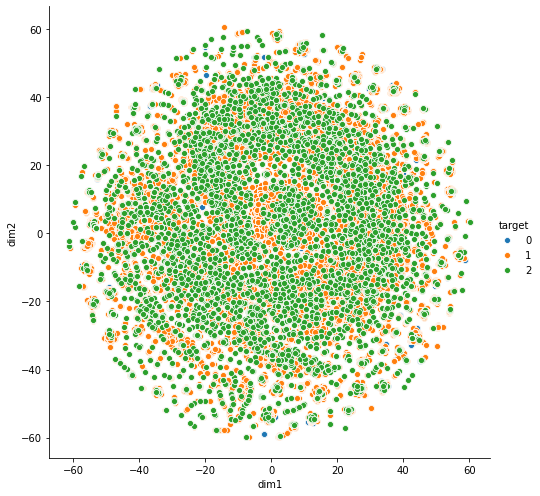

In [38]:
sns.FacetGrid(tsne_df, hue = 'target', size = 7).map(sns.scatterplot, 'dim1', 'dim2').add_legend()

There doesn't seem to be much of a separable boundary between the classes for the avg_wv featurization.
Let us use the TF-IDF featurization and see if we are able to see any separable boundary

Let us use the TF-IDF model that is built for vizualizing the high dimensional data. <br>
The time complexity of sklearn t-SNE is high, hence it is better to sample the data. <br>

In [39]:
tsne  = TSNE(n_components=2, perplexity=30, n_iter=1000)
x_train_sample_tsne = tsne.fit_transform(x_train_tfidf[:100000])

In [40]:
tsne_df = pd.concat([pd.DataFrame(x_train_sample_tsne), y_train[:100000]], axis = 1)
tsne_df.columns = ['dim1', 'dim2', 'target']

In [41]:
tsne_df.shape
tsne_df.head()

(100000, 3)

,dim1,dim2,target
0,-7.901115,5.033348,1
1,-7.863369,4.998171,1
2,-36.266747,31.011148,1
3,-36.655876,33.479183,1
4,-36.657207,33.478741,1


(-80.0, 80.0)

(100.0, -100.0)

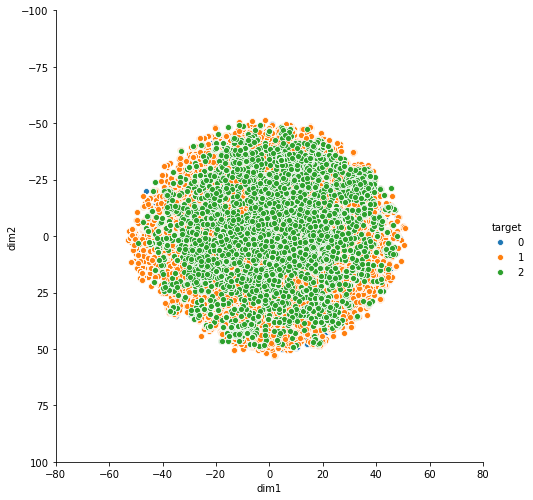

In [52]:
sns.FacetGrid(tsne_df, hue = 'target', size = 7).map(sns.scatterplot, 'dim1', 'dim2').add_legend()
plt.xlim((-80,80))
plt.ylim((100, -100))

## Machine Learning Models

In [16]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

### 1. Logistic Regression

#### Bag-of-Words + LR_Model

In [33]:
params = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
lr_model_bow = GridSearchCV(LogisticRegression(penalty='l2', class_weight= 'balanced'), n_jobs=-1, param_grid= params, verbose=1, cv = 10, scoring= 'neg_log_loss')
lr_model_bow.fit(x_train_bow, y_train)

print(lr_model_bow.best_estimator_)
lr_model_bow.score(x_train_bow, y_train)
lr_model_bow.score(x_test_bow, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.9min finished


GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000, 10000]}],
             scoring='neg_log_loss', verbose=1)

LogisticRegression(C=0.1, class_weight='balanced')


-0.3770294932235218

-0.6232329882120164

In [34]:
train_report = classification_report(y_true = y_train, y_pred = lr_model_bow.predict(x_train_bow))
test_report = classification_report(y_true = y_test, y_pred = lr_model_bow.predict(x_test_bow))

train_auc_ovr = roc_auc_score(y_train, lr_model_bow.predict_proba(x_train_bow), average = 'weighted', multi_class = 'ovr')
train_auc_ovo = roc_auc_score(y_train, lr_model_bow.predict_proba(x_train_bow), average = 'weighted', multi_class = 'ovo')

test_auc_ovr = roc_auc_score(y_test, lr_model_bow.predict_proba(x_test_bow), average = 'weighted', multi_class = 'ovr')
test_auc_ovo = roc_auc_score(y_test, lr_model_bow.predict_proba(x_test_bow), average = 'weighted', multi_class = 'ovo')

In [35]:
print('Train Report:')
print('Train_auc_one_vs_one:', train_auc_ovo)
print('Train_auc_one_vs_rest:', train_auc_ovr)
print(train_report)
print('*'*60)
print('Test_auc_one_vs_one:', test_auc_ovo)
print('Test_auc_one_vs_rest:', test_auc_ovr)
print('Test Report:')
print(test_report)

Train Report:
Train_auc_one_vs_one: 0.9683740166185264
Train_auc_one_vs_rest: 0.970172154379602
              precision    recall  f1-score   support

           0       0.74      0.88      0.81     54921
           1       0.98      0.87      0.93    313164
           2       0.46      0.86      0.60     28988

    accuracy                           0.87    397073
   macro avg       0.73      0.87      0.78    397073
weighted avg       0.91      0.87      0.89    397073

************************************************************
Test_auc_one_vs_one: 0.8514412848202804
Test_auc_one_vs_rest: 0.8915456886018462
Test Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.66     26802
           1       0.94      0.83      0.88    129803
           2       0.22      0.41      0.29     13570

    accuracy                           0.78    170175
   macro avg       0.59      0.65      0.61    170175
weighted avg       0.83      0.78      0.8

#### TF-IDF + LR_Model

In [36]:
params = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
lr_model_tfidf = GridSearchCV(LogisticRegression(penalty='l2', class_weight= 'balanced'), n_jobs=-1, param_grid= params, verbose=1, cv = 10, scoring= 'neg_log_loss')
lr_model_tfidf.fit(x_train_tfidf, y_train)

print(lr_model_tfidf.best_estimator_)
lr_model_tfidf.score(x_train_tfidf, y_train)
lr_model_tfidf.score(x_test_tfidf, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.4min finished


GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000, 10000]}],
             scoring='neg_log_loss', verbose=1)

LogisticRegression(C=1, class_weight='balanced')


-0.43300939916104764

-0.5721237496848669

In [9]:
def report_metrics(x,y,model, name = ''):
    report = classification_report(y_true = y, y_pred = model.predict(x))
    auc_ovr = roc_auc_score(y, model.predict_proba(x), average = 'weighted', multi_class = 'ovr')
    auc_ovo = roc_auc_score(y, model.predict_proba(x), average = 'weighted', multi_class = 'ovr')
    
    print(name+'_auc_one_vs_one:', auc_ovo)
    print(name+'_auc_one_vs_rest:', auc_ovr)
    print(report)
    print('*'*50)

In [37]:
train_report = classification_report(y_true = y_train, y_pred = lr_model_tfidf.predict(x_train_tfidf))
test_report = classification_report(y_true = y_test, y_pred = lr_model_tfidf.predict(x_test_tfidf))

train_auc_ovr = roc_auc_score(y_train, lr_model_tfidf.predict_proba(x_train_tfidf), average = 'weighted', multi_class = 'ovr')
train_auc_ovo = roc_auc_score(y_train, lr_model_tfidf.predict_proba(x_train_tfidf), average = 'weighted', multi_class = 'ovo')

test_auc_ovr = roc_auc_score(y_test, lr_model_tfidf.predict_proba(x_test_tfidf), average = 'weighted', multi_class = 'ovr')
test_auc_ovo = roc_auc_score(y_test, lr_model_tfidf.predict_proba(x_test_tfidf), average = 'weighted', multi_class = 'ovo')

In [38]:
print('Train Report:')
print('Train_auc_one_vs_one:', train_auc_ovo)
print('Train_auc_one_vs_rest:', train_auc_ovr)
print(train_report)
print('*'*60)
print('Test_auc_one_vs_one:', test_auc_ovo)
print('Test_auc_one_vs_rest:', test_auc_ovr)
print('Test Report:')
print(test_report)

Train Report:
Train_auc_one_vs_one: 0.9555120488006232
Train_auc_one_vs_rest: 0.9607850744237186
              precision    recall  f1-score   support

           0       0.71      0.84      0.77     54921
           1       0.98      0.85      0.91    313164
           2       0.39      0.81      0.53     28988

    accuracy                           0.85    397073
   macro avg       0.69      0.84      0.74    397073
weighted avg       0.90      0.85      0.86    397073

************************************************************
Test_auc_one_vs_one: 0.8734210379826668
Test_auc_one_vs_rest: 0.9085216974011998
Test Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.66     26802
           1       0.95      0.81      0.88    129803
           2       0.23      0.47      0.31     13570

    accuracy                           0.77    170175
   macro avg       0.60      0.66      0.61    170175
weighted avg       0.84      0.77      0.

#### AVG-W2V + LR_Model

In [39]:
std = StandardScaler().fit(x_train_avg_wv)
x_train_avg_wv_std = std.transform(x_train_avg_wv)
x_test_avg_wv_std = std.transform(x_test_avg_wv)

In [40]:
params = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
lr_model_w2v = GridSearchCV(LogisticRegression(penalty='l2', class_weight= 'balanced'), n_jobs=-1, param_grid= params, verbose=1, cv = 10, scoring= 'neg_log_loss')
lr_model_w2v.fit(x_train_avg_wv_std, y_train)

print(lr_model_w2v.best_estimator_)
lr_model_w2v.score(x_train_avg_wv_std, y_train)
lr_model_w2v.score(x_test_avg_wv_std, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.7min finished


GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                1000, 10000]}],
             scoring='neg_log_loss', verbose=1)

LogisticRegression(C=1000, class_weight='balanced')


-1.059164083846504

-1.0605619579361096

In [10]:
def report_metrics(x,y,model, name = ''):
    report = classification_report(y_true = y, y_pred = model.predict(x))
    auc_ovr = roc_auc_score(y, model.predict_proba(x), average = 'weighted', multi_class = 'ovr')
    auc_ovo = roc_auc_score(y, model.predict_proba(x), average = 'weighted', multi_class = 'ovr')
    
    print(name+'_auc_one_vs_one:', auc_ovo)
    print(name+'_auc_one_vs_rest:', auc_ovr)
    print(report)
    print('*'*50)

In [43]:
report_metrics(x = x_train_avg_wv_std, y = y_train, model = lr_model_w2v, name = 'train')
report_metrics(x = x_test_avg_wv_std, y = y_test, model = lr_model_w2v, name = 'test')

train_auc_one_vs_one: 0.6356761183904437
train_auc_one_vs_rest: 0.6356761183904437
              precision    recall  f1-score   support

           0       0.20      0.42      0.27     54921
           1       0.85      0.54      0.66    313164
           2       0.12      0.34      0.17     28988

    accuracy                           0.51    397073
   macro avg       0.39      0.44      0.37    397073
weighted avg       0.71      0.51      0.57    397073

**************************************************
test_auc_one_vs_one: 0.6317979123246721
test_auc_one_vs_rest: 0.6317979123246721
              precision    recall  f1-score   support

           0       0.23      0.43      0.30     26802
           1       0.83      0.54      0.65    129803
           2       0.12      0.33      0.18     13570

    accuracy                           0.50    170175
   macro avg       0.39      0.43      0.38    170175
weighted avg       0.68      0.50      0.56    170175

***********************

#### BERT + LR Model

In [10]:
std = StandardScaler().fit(train_bert_vectors)
x_train_bert_std = std.transform(train_bert_vectors)
x_test_bert_std = std.transform(test_bert_vectors)

In [12]:
params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
lr_model_bert = GridSearchCV(SGDClassifier(loss = 'log', penalty='l2', class_weight= 'balanced', random_state = 42), n_jobs=-1, param_grid= params, verbose=1, cv = 10, scoring= 'neg_log_loss')
lr_model_bert.fit(x_train_bert_std, y_train)

print(lr_model_bert.best_estimator_)
lr_model_bert.score(x_train_bert_std, y_train)
lr_model_bert.score(x_test_bert_std, y_test)

SGDClassifier(alpha=0.1, class_weight='balanced', loss='log', random_state=42)


-0.46862107251714885

-0.49662233460767935

In [13]:
report_metrics(x = x_train_bert_std, y = y_train, model = lr_model_bert, name = 'train')
report_metrics(x = x_test_bert_std, y = y_test, model = lr_model_bert, name = 'test')

train_auc_one_vs_one: 0.9057704147298052
train_auc_one_vs_rest: 0.9057704147298052
              precision    recall  f1-score   support

           0       0.61      0.64      0.62     54921
           1       0.92      0.91      0.91    313164
           2       0.32      0.31      0.32     28988

    accuracy                           0.83    397073
   macro avg       0.62      0.62      0.62    397073
weighted avg       0.83      0.83      0.83    397073

**************************************************
test_auc_one_vs_one: 0.9033468311273279
test_auc_one_vs_rest: 0.9033468311273279
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     26802
           1       0.91      0.90      0.90    129803
           2       0.31      0.31      0.31     13570

    accuracy                           0.82    170175
   macro avg       0.62      0.63      0.62    170175
weighted avg       0.82      0.82      0.82    170175

***********************

## Deep Learning Models

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers

In [18]:
max_words = 50000
max_len = 200
tokenizer = Tokenizer(num_words=50000)

tokenizer.fit_on_texts(train_data.cleaned_text_wv)

train_sequences = tokenizer.texts_to_sequences(train_data.cleaned_text_wv)
test_sequences = tokenizer.texts_to_sequences(test_data.cleaned_text_wv)

train_sequences = pad_sequences(train_sequences, maxlen= max_len, padding='pre')
test_sequences =  pad_sequences(test_sequences, maxlen= max_len, padding='pre')

In [19]:
y_train = train_data.numeric_score.values.copy()
y_test = test_data.numeric_score.values.copy()

x_train = train_sequences.copy()
x_test = test_sequences.copy()

In [20]:
x_train.shape
y_train.shape

x_test.shape
y_test.shape

(397073, 200)

(397073,)

(170175, 200)

(170175,)

### Simple dense Model with flattening the word vectors 

In [56]:
model = models.Sequential()
model.add(layers.Embedding(input_dim= max_words, output_dim=300, input_length=max_len))
model.add(layers.Flatten())

model.add(layers.Dense(300, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(rate = 0.2))

model.add(layers.Dense(150, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(rate = 0.2))

model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               18000300  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [57]:
history = model.fit(x_train, y_train, batch_size = 2048, epochs = 20, validation_split = 0.2, shuffle = True)

Epoch 1/20
156/156 [==============================] - 48s 310ms/step - loss: 1.4113 - acc: 0.8292 - val_loss: 0.6062 - val_acc: 0.8452
Epoch 2/20
156/156 [==============================] - 48s 306ms/step - loss: 0.4766 - acc: 0.8719 - val_loss: 0.5094 - val_acc: 0.8485
Epoch 3/20
156/156 [==============================] - 48s 305ms/step - loss: 0.4129 - acc: 0.8833 - val_loss: 0.5338 - val_acc: 0.8437
Epoch 4/20
156/156 [==============================] - 51s 324ms/step - loss: 0.3847 - acc: 0.8932 - val_loss: 0.5421 - val_acc: 0.8440
Epoch 5/20
156/156 [==============================] - 48s 310ms/step - loss: 0.3631 - acc: 0.9022 - val_loss: 0.5589 - val_acc: 0.8463
Epoch 6/20
156/156 [==============================] - 48s 309ms/step - loss: 0.3406 - acc: 0.9143 - val_loss: 0.6016 - val_acc: 0.8476
Epoch 7/20
156/156 [==============================] - 50s 319ms/step - loss: 0.3197 - acc: 0.9280 - val_loss: 0.6162 - val_acc: 0.8427
Epoch 8/20
156/156 [==============================] - 4

In [58]:
no_epochs = np.arange(1,21)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, '# Epochs')

Text(0, 0.5, 'Loss')

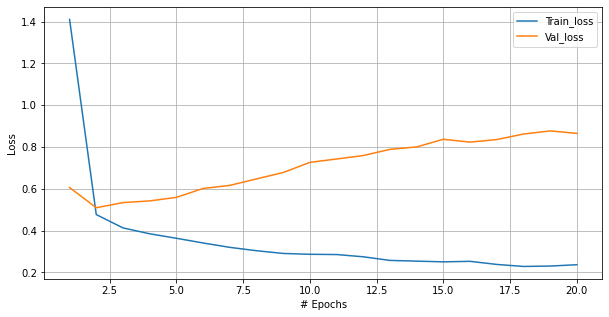

In [61]:
plt.figure(figsize = (10,5))
plt.plot(no_epochs, train_loss, label = 'Train_loss')
plt.plot(no_epochs, val_loss, label = 'Val_loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

<Figure size 1440x576 with 0 Axes>

Text(0.5, 0, '# Epochs')

Text(0, 0.5, 'Loss')

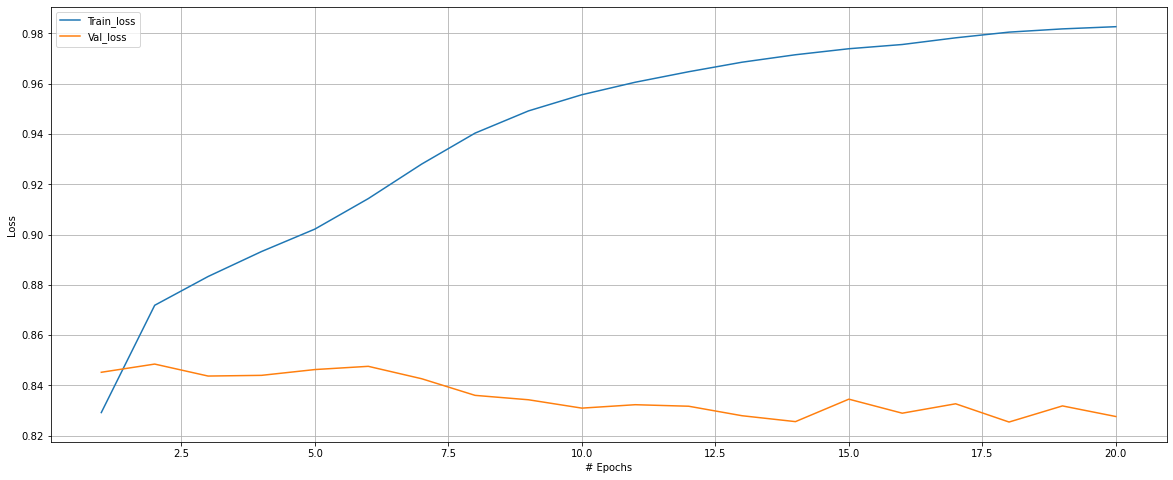

In [62]:
plt.figure(figsize = (20,8))
plt.plot(no_epochs, train_acc, label = 'Train_loss')
plt.plot(no_epochs, val_acc, label = 'Val_loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [16]:
model = models.Sequential([
    layers.Embedding(input_dim = max_words, output_dim = 300, input_length = max_len),
    layers.GlobalAveragePooling1D(),
    
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.1),
    
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.1),
    
    layers.Dense(3, activation = 'softmax')
])
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                19264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [17]:
history = model.fit(x_train, y_train, batch_size = 2048, epochs = 20, validation_split = 0.2, shuffle = True)

Epoch 1/20
156/156 [==============================] - 63s 402ms/step - loss: 0.6217 - acc: 0.7952 - val_loss: 0.4768 - val_acc: 0.8179
Epoch 2/20
156/156 [==============================] - 62s 396ms/step - loss: 0.3748 - acc: 0.8628 - val_loss: 0.3929 - val_acc: 0.8557
Epoch 3/20
156/156 [==============================] - 62s 400ms/step - loss: 0.3193 - acc: 0.8818 - val_loss: 0.3825 - val_acc: 0.8606
Epoch 4/20
156/156 [==============================] - 66s 421ms/step - loss: 0.2871 - acc: 0.8947 - val_loss: 0.4056 - val_acc: 0.8506
Epoch 5/20
156/156 [==============================] - 64s 409ms/step - loss: 0.2680 - acc: 0.9030 - val_loss: 0.3949 - val_acc: 0.8539
Epoch 6/20
156/156 [==============================] - 63s 404ms/step - loss: 0.2493 - acc: 0.9114 - val_loss: 0.4160 - val_acc: 0.8533
Epoch 7/20
156/156 [==============================] - 63s 405ms/step - loss: 0.2335 - acc: 0.9179 - val_loss: 0.4260 - val_acc: 0.8467
Epoch 8/20
156/156 [==============================] - 6

In [20]:
no_epochs = np.arange(1,21)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, '# Epochs')

Text(0, 0.5, 'Loss')

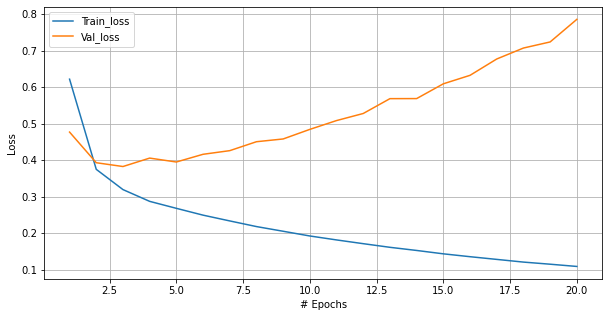

In [21]:
no_epochs = range(1,21)
plt.figure(figsize = (10,5))
plt.plot(no_epochs, train_loss, label = 'Train_loss')
plt.plot(no_epochs, val_loss, label = 'Val_loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

<Figure size 1440x576 with 0 Axes>

Text(0.5, 0, '# Epochs')

Text(0, 0.5, 'Loss')

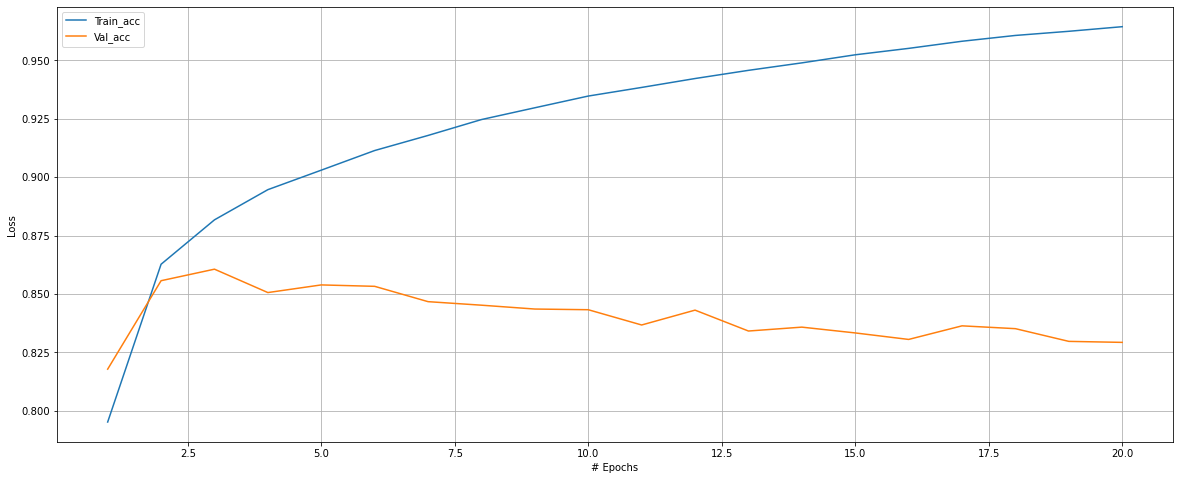

In [23]:
plt.figure(figsize = (20,8))
plt.plot(no_epochs, train_acc, label = 'Train_acc')
plt.plot(no_epochs, val_acc, label = 'Val_acc')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [26]:
model = models.Sequential([
    layers.Embedding(input_dim = max_words, output_dim = 300, input_length = max_len),
    
    layers.LSTM(64,activation = 'tanh',  return_sequences = True),
    layers.LSTM(32, activation = 'tanh'),    
    layers.Dense(3, activation = 'softmax')
])
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 64)           93440     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 15,126,659
Trainable params: 15,126,659
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(x_train, y_train, batch_size = 2048, epochs = 5, validation_split = 0.2, shuffle = True)

Epoch 1/5
156/156 [==============================] - 143s 919ms/step - loss: 0.3839 - acc: 0.8580 - val_loss: 0.3913 - val_acc: 0.8542
Epoch 2/5
156/156 [==============================] - 142s 909ms/step - loss: 0.2795 - acc: 0.8979 - val_loss: 0.3820 - val_acc: 0.8570
Epoch 3/5
156/156 [==============================] - 139s 892ms/step - loss: 0.2268 - acc: 0.9195 - val_loss: 0.3927 - val_acc: 0.8531
Epoch 4/5
156/156 [==============================] - 141s 903ms/step - loss: 0.1844 - acc: 0.9359 - val_loss: 0.4175 - val_acc: 0.8631
Epoch 5/5
156/156 [==============================] - 140s 899ms/step - loss: 0.1507 - acc: 0.9490 - val_loss: 0.4496 - val_acc: 0.8593


In [29]:
model.evaluate(x_test, y_test)

5318/5318 [==============================] - 62s 12ms/step - loss: 0.4669 - acc: 0.8552


[0.4668771028518677, 0.8552314043045044]

In [13]:
model = models.Sequential([
    layers.Embedding(input_dim = max_words, output_dim = 300, input_length = max_len),
    
    layers.Bidirectional(layers.LSTM(32, activation = 'tanh',  return_sequences = True)),
    layers.Bidirectional(layers.LSTM(16, activation = 'tanh')),
    layers.Dense(3, activation = 'softmax')
])
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 64)           85248     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 15,095,715
Trainable params: 15,095,715
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train, y_train, batch_size = 1024, epochs = 5, validation_split = 0.2, shuffle = True)

Epoch 1/5
311/311 [==============================] - 79s 254ms/step - loss: 0.4137 - acc: 0.8533 - val_loss: 0.3897 - val_acc: 0.8583
Epoch 2/5
311/311 [==============================] - 79s 253ms/step - loss: 0.2678 - acc: 0.9023 - val_loss: 0.3752 - val_acc: 0.8591
Epoch 3/5
311/311 [==============================] - 80s 257ms/step - loss: 0.2083 - acc: 0.9269 - val_loss: 0.3823 - val_acc: 0.8628
Epoch 4/5
311/311 [==============================] - 80s 258ms/step - loss: 0.1633 - acc: 0.9448 - val_loss: 0.4069 - val_acc: 0.8573
Epoch 5/5
311/311 [==============================] - 80s 256ms/step - loss: 0.1309 - acc: 0.9570 - val_loss: 0.4546 - val_acc: 0.8612


## Residual Connections in NN

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [22]:
max_words = 50_000
max_len = 200

tokenizer = Tokenizer(num_words= max_words)
tokenizer.fit_on_texts(train_data.cleaned_text_wv)

train_sequences = tokenizer.texts_to_sequences(train_data.cleaned_text_wv) 
test_sequences = tokenizer.texts_to_sequences(test_data.cleaned_text_wv)

train_sequences = pad_sequences(train_sequences, maxlen= max_len, padding= 'pre')
test_sequences = pad_sequences(test_sequences, maxlen= max_len, padding= 'pre')

In [25]:
y_train = train_data.numeric_score.values.copy()
y_test = test_data.numeric_score.values.copy()

x_train = train_sequences.copy()
x_test = test_sequences.copy()

In [26]:
x_train.shape
y_train.shape

x_test.shape
y_test.shape

(397073, 200)

(397073,)

(170175, 200)

(170175,)

In [49]:
inp = Input(shape= (200,), dtype= 'int32', name = 'text')

emb_text = layers.Embedding(input_dim = max_words, input_length = max_len, output_dim = 300, name = 'emb_layer')(inp)
avg_wv = layers.GlobalAveragePooling1D(name = 'avg_wv_layer')(emb_text)

dense_1 = layers.Dense(32, activation = 'relu', name = 'dense_1')(avg_wv)
dropout1 = layers.Dropout(0.1, name = 'dropout1')(dense_1)

dense_2 = layers.Dense(64, activation = 'relu', name = 'dense_2')(dropout1)
dropout2 = layers.Dropout(0.3, name = 'dropout2')(dense_2)

dense_3 = layers.Dense(64, activation = 'relu', name = 'dense_3')(dropout2)
dropout3 = layers.Dropout(0.2, name = 'dropout3')(dense_3)

residual = layers.Dense(64)(avg_wv)
resnet_conn = layers.add([dropout3, residual])

dense_4 = layers.Dense(32, activation = 'relu', name = 'dense_4')(resnet_conn)
dropout4 = layers.Dropout(0.1, name = 'dropout4')(dense_4)


output_layer = layers.Dense(3, activation = 'softmax')(dropout4)

model = Model(inp, output_layer)
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [50]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
emb_layer (Embedding)           (None, 200, 300)     15000000    text[0][0]                       
__________________________________________________________________________________________________
avg_wv_layer (GlobalAveragePool (None, 300)          0           emb_layer[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           9632        avg_wv_layer[0][0]               
______________________________________________________________________________________

In [51]:
model.fit(x_train, y_train, epochs=5, batch_size = 1024, validation_split= 0.2, shuffle = True)

Epoch 1/5
311/311 [==============================] - 59s 190ms/step - loss: 0.4975 - acc: 0.8284 - val_loss: 0.3947 - val_acc: 0.8542
Epoch 2/5
311/311 [==============================] - 59s 190ms/step - loss: 0.3205 - acc: 0.8804 - val_loss: 0.3813 - val_acc: 0.8558
Epoch 3/5
311/311 [==============================] - 60s 194ms/step - loss: 0.2778 - acc: 0.8976 - val_loss: 0.3937 - val_acc: 0.8495
Epoch 4/5
311/311 [==============================] - 62s 199ms/step - loss: 0.2477 - acc: 0.9108 - val_loss: 0.4127 - val_acc: 0.8460
Epoch 5/5
311/311 [==============================] - 57s 183ms/step - loss: 0.2210 - acc: 0.9220 - val_loss: 0.4346 - val_acc: 0.8452


In [52]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

12409/12409 [==============================] - 25s 2ms/step - loss: 0.2372 - acc: 0.9181


[0.23719221353530884, 0.9181208610534668]

5318/5318 [==============================] - 11s 2ms/step - loss: 0.4439 - acc: 0.8437


[0.4439324736595154, 0.8437079191207886]